# **Volume**

### 개요
* Container가 외부 스토리지에 액세스하고 공유하는 방법.
* Pod의 각 Container에는 고유의 분류된 파일 시스템이 존재.
  * Volume은 Pod의 컴포넌트이며, Pod의 `spec` object에 정의(독립적인 Kuberentes 리소스가 아니며 스스로 생성, 삭제 불가).
  * 각 Container의 파일 시스템의 Volume을 마운트하여 생성.

### Volume의 종류

| 구분 | 목록 | 특징 |
| --- | --- | --- |
| 임시 Volume | emptyDir | * 임시 Volume으로 Container가 삭제되면 함께 삭제됨<br/>* 데이터 유지가 아닌 Container끼리 데이터를 공유하기 위한 Volume |
| 로컬(=Node) Volume | hostpath<br/>local | * Pod가 떠있는 Node에서만 보관됨<br/>* 데이터 유지가 아닌 Node 관리를 목적으로 하는 Volume(Node와 데이터를 공유하기 위한 Volume) |
| 네트워크 Volume | iSCSI<br/>NFS<br/>cephFS<br/>glusterFS... | 외부와 데이터를 공유하기 위한 Volume |
| 네트워크 Volume<br/>(클라우드 종속적) | gcePersistentDisk<br/>awsEBS<br/>azureFile | |

# emptyDir Volume을 활용한 파일 시스템 공유

### 사례 비교를 통해 emptyDir 필요성 알아보기

* Pod가 죽으면 Container 데이터가 모두 사라지는 것은 동일

사례 1은 Container간 데이터 공유가 불가능하고, 사례 2는 Container간 공유가 가능하다.

* 사례 1: 공유 스토리지가 없는 동일한 Pod의 3개의 Container

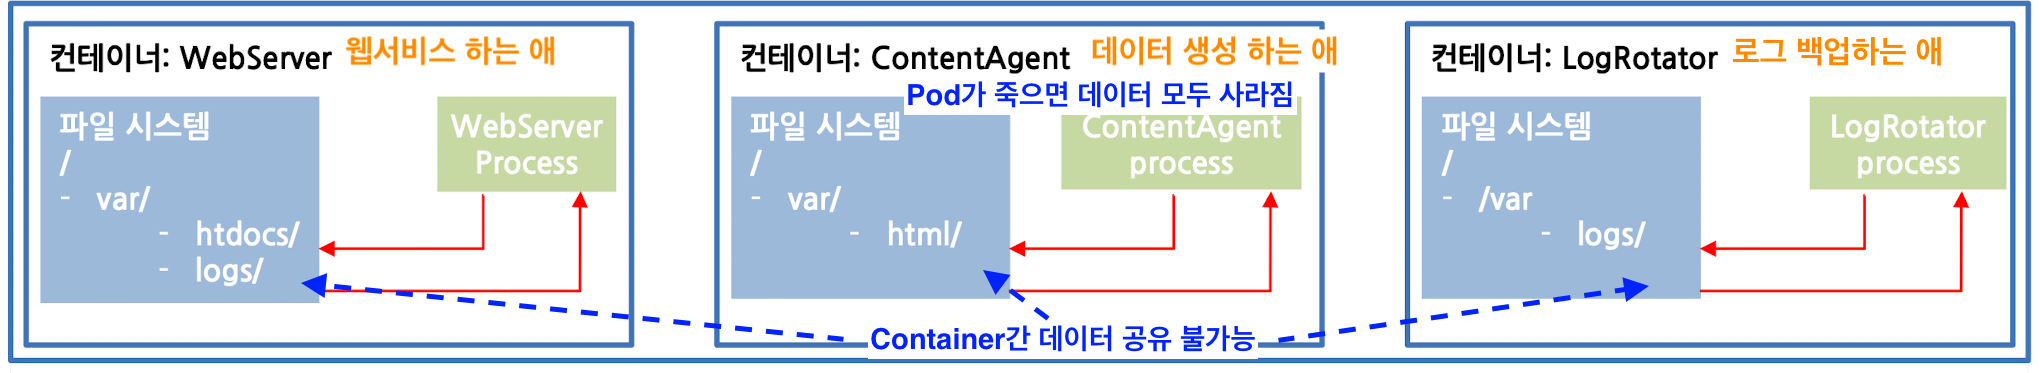

* 사례 2: 2개의 볼륨을 공유하는 동일한 Pod의 3개의 Container

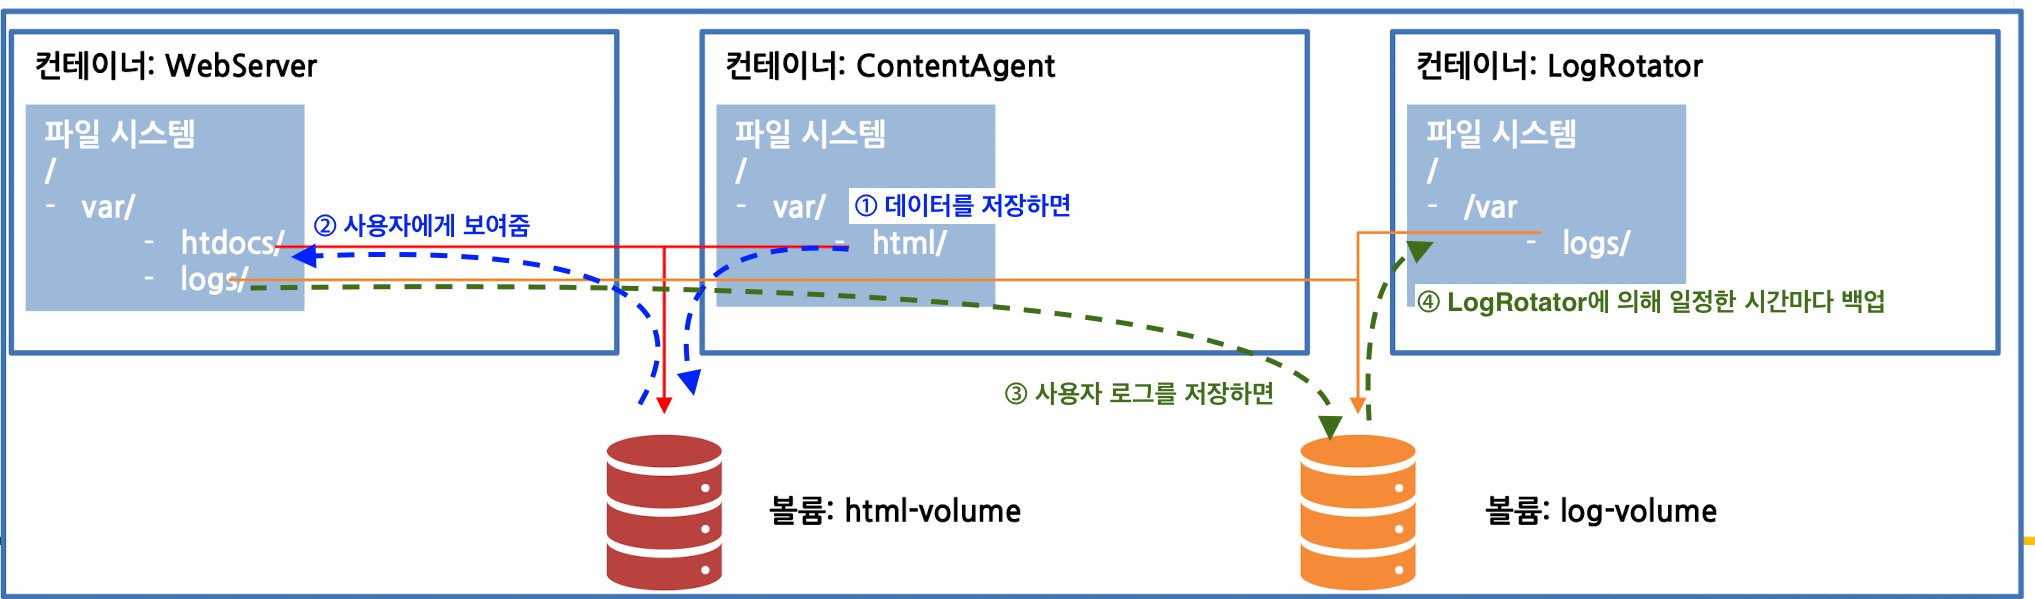

* Volume을 공유하는 애플리케이션 원리 이해

실습용 애플리케이션으로 **Volume 경로에 10초에 한 번씩 데이터를 생성하여 웹서비스와 공유할 수 있는지 테스트하기 위해 사용**된다. 동작 원리를 위해 추가하였으며, 도커 허브의 `gasbugs/count` 이미지에 포함된 내부 애플리케이션이므로 **실습 때는 이미지를 가져다 사용하면 된다.**

> 애플리케이션 코드 일부
```
for i in $SET

do
    echo "Running loop seq "$i > /var/htdocs/index.html
    sleep 10
done
```

* emptyDir Volume 사용

emptyDir Volume을 공유하는 2개의 Container를 띄우는 Pod YAML을 작성한다.


> count-httpd.yaml
```
apiVersion: v1
kind: Pod
metadata:
  name: count
spec:
  containers:
  - image: gasbugs/count
    name: html-generator
    volumeMounts:
    - mountPath: /var/htdocs
      name: html
  - image: httpd
    name: web-server
    volumeMounts:
    - mountPath: /usr/local/apache2/htdocs
      name: html
      readOnly: true    <-- html-generator만 Write가 가능해짐
    ports:
    - containerPort: 80
  volumes:
  - name: html
    emptyDir: {}
```

* emptyDir Volume을 공유하는 2개의 Container를 띄우는 Pod YAML 실행

```
$ kubectl create -f count-httpd.yaml
pod/count created
```

* 확인

```
$ kubectl get pod -o wide
NAME                       READY   STATUS    RESTARTS   AGE     IP          NODE      NOMINATED NODE   READINESS GATES
count                      2/2     Running   0          4m12s   10.40.0.2   worker1   <none>           <none>
```

* 다른 Pod에서 웹서버로 요청 보내서 테스트

http-go Pod 사용(없으면 하나 만드세요)
```
$ kubectl get pod -o wide
NAME                       READY   STATUS    RESTARTS   AGE     IP          NODE      NOMINATED NODE   READINESS GATES
count                      2/2     Running   0          4m12s   10.40.0.2   worker1   <none>           <none>
http-go-5c6f458dc9-m97w8   1/1     Running   0          23h     10.32.0.4   worker2   <none>           <none>
```

요청시 응답 확인
```
$ kubectl exec -it http-go-5c6f458dc9-m97w8 -- curl 10.40.0.2
Running loop seq 27
```

# hostPath Volume을 활용한 파일 시스템 공유

### 개요

* Node의 파일 시스템에 있는 특정 파일 또는 디렉토리 지정하여 마운트.
* Pod가 내려가도 남아있는 영구 스토리지
* Node의 쿠버네티스 리소스를 모니터링용하고 로그를 기록하는데 많이 사용.
* 다른 Node의 Pod끼리 데이터 공유는 불가능.

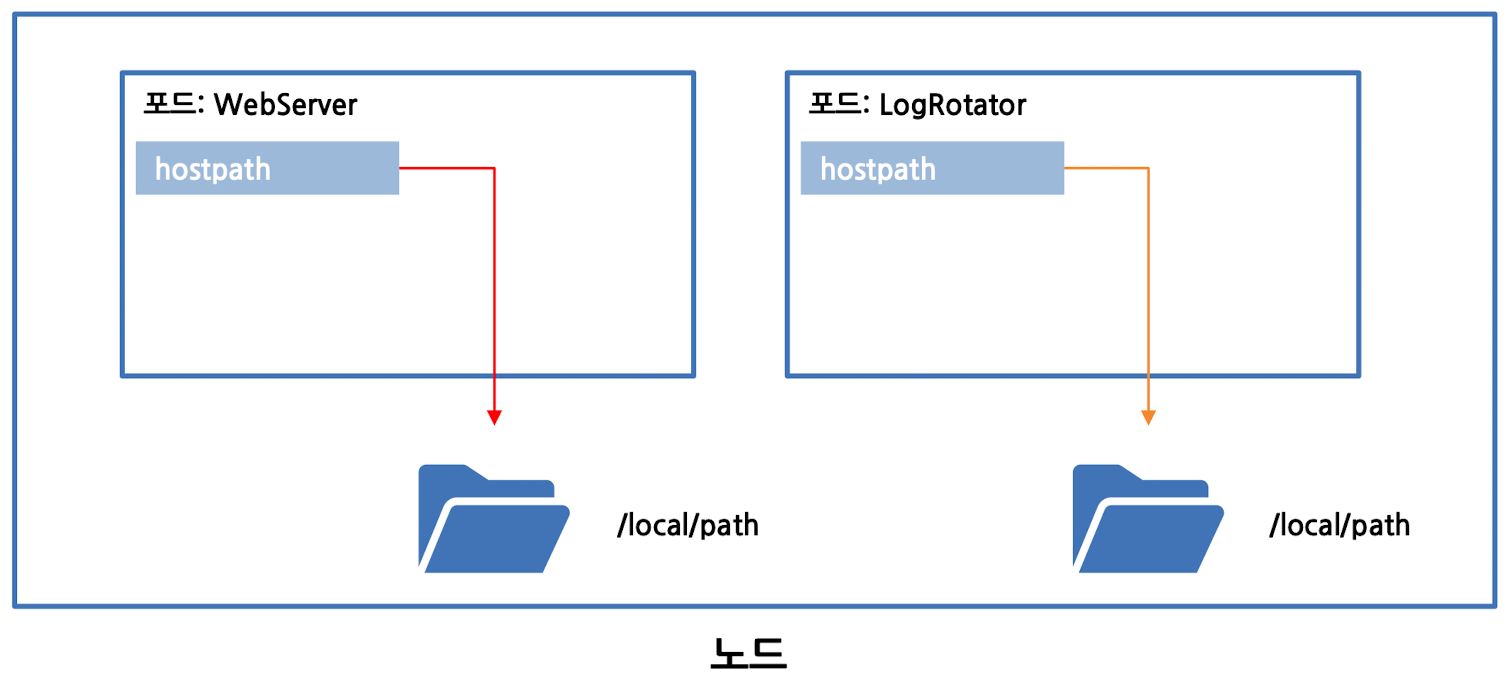

### GKE 모니터링에 사용되는 hostPath 살펴보기(GKE에서 진행, On-premise는 따로 모니터링 설치 해줘야 함)

* Monitoring Pod가 떠있음
```
$ kubectl get pods -n kube-system
NAME                          READY     STATUS      RESTARTS    AGE
(중략)
fluentd-gcp-v3.2.0-fgc7k      2/2       Running     0           46h
(중략)
```

* Docker가 가진 Container의 로그
```
$ kubectl describe pod fluentd-gcp-v3.2.0-fgc7k -n kube-system
Name:                 fluent-gcp-v3.2.0-fgc7k
Namespace:            kube-system
(중략)
Volumes:
  varlog:
    Type:             HostPath (bare host directory volume)
    Path:             /var/log
    HostPathType:     
  varlibdockercontainers:
    Type:             HostPath (bare host directory volume)
    Path:             /var/lib/docker/containers
    HostPathType:
(중략)
```

이런 식으로 노드의 쿠버네티스 리소스 모니터링 및 로그 정보를 수집하기 위해서 hostPath Volume을 사용!

### hostPath Volume 실습

* Worker Node 파일 시스템에 hostPath Volume을 생성

Worker Node1에서 아래 명령어 수행
```
# sudo mkdir /var/htdocs
# sudo echo "work1" > /var/htdocs/index.html
# cat /var/htdocs/index.html
```

Worker Node1에서 아래 명령어 수행.
```
# sudo mkdir /var/htdocs
# sudo echo "work2" > /var/htdocs/index.html
# cat /var/htdocs/index.html
```

* hostPath Volume을 공유하는 Pod YAML 작성

(참고) [kubernetes docs] > "volume" 검색 > [hostPath] 선택해서 참고

> hostpath-http.yaml
```
apiVersion: v1
kind: Pod
metadata:
  name: hostpath-http
spec:
  containers:
  - image: httpd
    name: web-server
    volumeMounts:
    - mountPath: /usr/local/apache2/htdocs
      name: html
      readOnly: true
    ports:
    - containerPort: 80
  volumes:
  - name: html
    hostPath:
      path: /var/htdocs/
      type: Directory
```

* hostPath Volume을 공유하는 Pod YAML 실행

```
$ kubectl create -f hostpath-http.yaml
pod/hostpath-http created
```

* 확인
```
$ kubectl get pod -w
NAME                       READY   STATUS    RESTARTS   AGE
hostpath-http              1/1     Running   0          71s
```

* Volume 마운트가 잘 됐는지 테스트하기 위해, 외부 접속 가능하게 `port-forward` 명령 실행
```
$ kubectl port-forward hostpath-http 8888:80
Forwarding from 127.0.0.1:8888 -> 80
Forwarding from [::1]:8888 -> 80
```

* Pod의 웹서비스에 접속해서 **Pod가 Node의 hostPath Volume 데이터를 읽어오는 것**을 확인하여 어느 Node에서 실행했는지 알 수 있음
```
$ curl -i 127.0.0.1:8888
HTTP/1.1 200 OK
Date: Tue, 15 Sep 2020 07:49:09 GMT
Server: Apache/2.4.46 (Unix)
Last-Modified: Tue, 15 Sep 2020 07:35:57 GMT
ETag: "6-5af5533af28ee"
Accept-Ranges: bytes
Content-Length: 6
Content-Type: text/html

work2       <-- work2에서 Pod가 실행 중인 것 확인 가능
```

* `kubectl` 명령어로 확인해보면 work2에서 Pod가 실행중인 것이 맞는 것을 확인 가능 
```
$ kubectl get pod -o wide
NAME                       READY   STATUS    RESTARTS   AGE     IP          NODE      NOMINATED NODE   READINESS GATES
hostpath-http              1/1     Running   0          5m14s   10.32.0.5   worker2   <none>           <none>
```